In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
from Higgs.tools.ImplementationUtils import (
    implementChainDecayLimit,
    read_csv_from_web,
)
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions

import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
import MassResolutions as resolution

BR_Z_ll = 2 * 3.3658e-2  # from 2020 PDG


# CMS 13TeV LHC

## `pp > hSM > Z a > ll gamgam` [2311.00130](https://arxiv.org/abs/2311.00130)

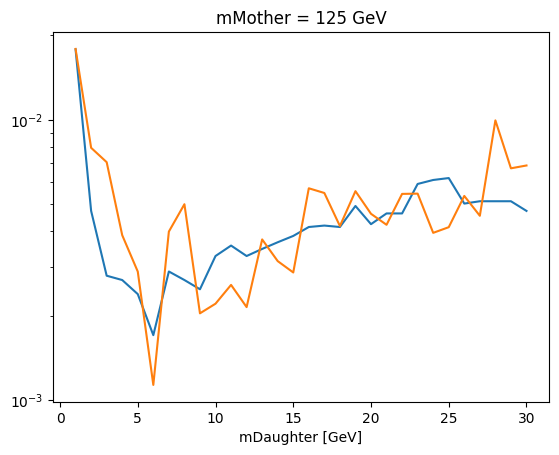

Looks good. Saving this to H_LHC13_CMS_138.json


/tmp/ipykernel_494053/3632798556.py:83: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  expCc.collections[0].set_label("expRatio = 1")
/tmp/ipykernel_494053/3632798556.py:84: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  obsCc.collections[0].set_label("obsRatio = 1")


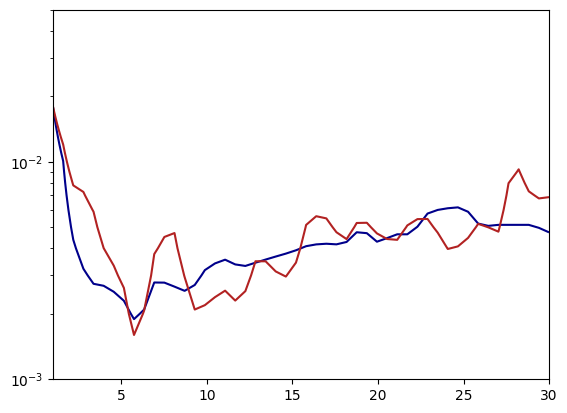

In [6]:
df = read_csv_from_web(
    "https://www.hepdata.net/download/table/ins2716400/Cross-section%20limits/1/csv",
    comment="#",
    skiprows=8,
    skipfooter=75 - 39,
    engine="python",
    names=["mDaughter", "obs"],
)
dfexp = read_csv_from_web(
    "https://www.hepdata.net/download/table/ins2716400/Cross-section%20limits/1/csv",
    comment="#",
    skiprows=43,
    skipfooter=75 - 74,
    engine="python",
    names=["m", "exp", "1d+", "1d-", "2d+", "2d-"],
)
df["exp"] = dfexp.exp
df.exp *= 1e-3  # fb to pb
df.obs *= 1e-3  # fb to pb
assert np.allclose(df.mDaughter, dfexp.m)
df["mMother"] = 125

limitFile = implementChainDecayLimit(
    2716400,
    {"production": ["H"], "chain": "Z", "decay": ["gamgam"]},
    "Fig. 7",
    df,
    idSuffix=1,
    massResolution={
        "daughter": {
            "absolute": 0.0,
            "relative": 0.045,
        },
        "mother": {
            "absolute": 5.0,
            "relative": 0.04,
        },
    },
    constraints={
        'daughter':[{'CPValue': 'odd'}],
    },
)

lim = HB.Limit(limitFile)


pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh", "even"))
a = pred.addParticle(HP.NeutralScalar("a", "odd"))
hh.setDecayWidth("Z", "a", 1.0)
a.setDecayWidth("gamgam", 1.0)
hh.setMass(125)
hm = np.linspace(1, 30)
r = np.linspace(1e-3, 5e-2)


def testAgainstLimit(mass, rate):
    a.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)

fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(XX, YY, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(XX, YY, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")